# Search a model to apply vmap on photometry


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- CC: kernel conda_jax0235_py310
- creation date : 2023-11-15
- update : 2023-11-15 : add interpax interpolation and fitted sfr, and filter object and pytree


| computer | processor | kernel              |    date     |
| --- | --- | --- | --- |
| CC       | CPU       | conda_jax0325_py310 | 2023-11-10  |
| macbookpro | CPU | conda_jaxcpu_dsps_py310 | 2023-11-10  | 


libraries 
=========

jax
---

- jaxlib-0.3.25+cuda11.cudnn82
- jaxopt
- optax
- corner
- arviz
- numpyro
- interpax

sps
---

- fsps
- prospect
- dsps
- diffstar
- diffmah
- sedpy or astro-sedpy

plot
----

- matplotlib
- seaborn

(conda_jax0325_py310) 
`/pbs/throng/lsst/users/dagoret/desc/StellarPopulationSynthesis>pip list | grep` 

| lib | version |
|--- | --- | 
|jax  |                         0.4.20 |
|jaxlib |                       0.4.20 |
|jaxopt  |                      0.8.2 |



In [1]:
import jax
import jax.numpy as jnp
jax.devices()

[CpuDevice(id=0)]

In [2]:
from sedpy import observate

In [3]:
import numpy as np

In [4]:
import jax
import jax.numpy as jnp
import jax.scipy as jsc

from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian

import jaxopt
import optax

jax.config.update("jax_enable_x64", True)

In [5]:
import itertools

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from collections import OrderedDict
import re
import matplotlib.gridspec as gridspec

In [7]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [8]:
class FilterInfo():
    def __init__(self):
        self.filters_galex = np.array(["galex_FUV","galex_NUV"])
        self.filters_sdss = np.array(["sdss_u0","sdss_g0","sdss_r0","sdss_i0"])
        self.filters_vircam = np.array(["vista_vircam_Z","vista_vircam_Y","vista_vircam_J","vista_vircam_H","vista_vircam_Ks"])

        # Galex filters
        self.all_filt_galex = []
        for filtname in self.filters_galex:
            filt = observate.Filter(filtname)
            self.all_filt_galex.append(filt)   
        self.N_galex = len(self.all_filt_galex)
        # colors for Galex
        cmap = mpl.cm.PuBu
        cNorm = colors.Normalize(vmin=0, vmax=self.N_galex)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
        self.all_colors_galex = scalarMap.to_rgba(np.arange(self.N_galex+1), alpha=1)

        # SDSS filters (for KIDS survey)
        self.all_filt_sdss = []
        for filtname in self.filters_sdss:
            filt = observate.Filter(filtname)
            self.all_filt_sdss.append(filt)  
        self.N_sdss = len(self.all_filt_sdss)
        # colors for SDSS
        cmap = mpl.cm.Reds
        cNorm = colors.Normalize(vmin=0, vmax=self.N_sdss)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
        self.all_colors_sdss = scalarMap.to_rgba(np.arange(self.N_sdss+1), alpha=1)

        # VIRCAM
        self.all_filt_vircam = []
        for filtname in self.filters_vircam:
            filt = observate.Filter(filtname)
            self.all_filt_vircam.append(filt) 
        self.N_vircam = len(self.all_filt_vircam)
        # colors for Vircam
        cmap = mpl.cm.Wistia
        cNorm = colors.Normalize(vmin=0, vmax=self.N_vircam)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
        self.all_colors_vircam = scalarMap.to_rgba(np.arange(self.N_vircam+1), alpha=1)
        


        self.filters_indexlist = []
        self.filters_surveylist = []
        self.filters_namelist = []
        self.filters_transmissionlist = []
        self.filters_transmissionnormlist = []
        self.filters_colorlist = []
        
        filter_count = 0
        
        for index in range(self.N_galex):
            self.filters_indexlist.append(filter_count)
            self.filters_surveylist.append("galex") 
            self.filters_namelist.append(self.filters_galex[index])
            self.filters_transmissionlist.append(self.all_filt_galex[index])
            self.filters_transmissionnormlist.append(100.0)
            self.filters_colorlist.append(self.all_colors_galex[index+1])
            filter_count+= 1
            
        for index in range(self.N_sdss):
            self.filters_indexlist.append(filter_count)
            self.filters_surveylist.append("sdss") 
            self.filters_namelist.append(self.filters_sdss[index])
            self.filters_transmissionlist.append(self.all_filt_sdss[index])
            self.filters_transmissionnormlist.append(1.0)
            self.filters_colorlist.append(self.all_colors_sdss[index+1])
            filter_count+= 1
            
        for index in range(self.N_vircam):
            self.filters_indexlist.append(filter_count)
            self.filters_surveylist.append("vircam") 
            self.filters_namelist.append(self.filters_vircam[index])
            self.filters_transmissionlist.append(self.all_filt_vircam[index])
            if index==0:
                self.filters_transmissionnormlist.append(100.0)
            else:
                self.filters_transmissionnormlist.append(1.0)
            self.filters_colorlist.append(self.all_colors_vircam[index+1])
            filter_count+= 1

    def get_pytree(self):
        """
        return a dict of a tuple of a dict
        """
        the_dict = {}
        
        for index in self.filters_indexlist:
            the_subdict = {}
            the_filt = self.filters_transmissionlist[index]
            the_norm = self.filters_transmissionnormlist[index]

            the_name = self.filters_namelist[index]
            the_wlmean = the_filt.wave_mean
            the_wls = the_filt.wavelength
            the_transm =the_filt.transmission/the_norm
            
            #the_subdict["name"] = the_name 
            #the_subdict["wlmean"] = the_wlmean
            the_subdict["wls"] = jnp.array(the_wls)
            the_subdict["transm"] = jnp.array(the_transm)
            the_dict[index] = the_subdict
            
        return the_dict
            
        

    def plot_transmissions(self,ax = None):

        if ax == None:
            fig,ax = plt.subplots(1,1,figsize=(12,6))
        
        for index in self.filters_indexlist:
            the_name = self.filters_namelist[index]
            the_filt = self.filters_transmissionlist[index]
            the_norm = self.filters_transmissionnormlist[index]
            the_wlmean = the_filt.wave_mean
            the_color = self.filters_colorlist[index]
            the_transmission =the_filt.transmission/the_norm
            ax.plot(the_filt.wavelength,the_transmission,color=the_color)   

            if index%2 ==0:
                ax.text(the_wlmean, 0.7, the_name,horizontalalignment='center',verticalalignment='center',color=the_color,fontweight="bold") 
            else:
                ax.text(the_wlmean, 0.75, the_name,horizontalalignment='center',verticalalignment='center',color=the_color,fontweight="bold") 
        

        ax.grid()
        ax.set_title("Transmission")
        ax.set_xlabel("$\lambda (\AA)$")
        ax.set_xlim(0.,25000.)

    def dump(self):
        print("filters_indexlist   : \t ", self.filters_indexlist)
        print("filters_surveylist  : \t ", self.filters_surveylist)
        print("filters__namelist   : \t ", self.filters_namelist)
                

In [9]:
photometric_surveys = FilterInfo()

filters_indexlist   : 	  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
filters_surveylist  : 	  ['galex', 'galex', 'sdss', 'sdss', 'sdss', 'sdss', 'vircam', 'vircam', 'vircam', 'vircam', 'vircam']
filters__namelist   : 	  ['galex_FUV', 'galex_NUV', 'sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'vista_vircam_Z', 'vista_vircam_Y', 'vista_vircam_J', 'vista_vircam_H', 'vista_vircam_Ks']


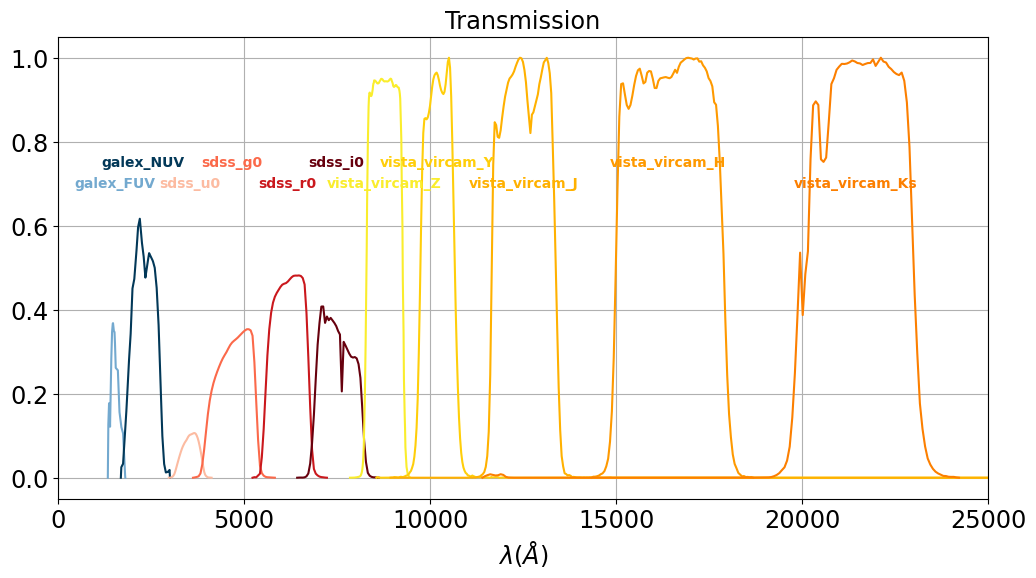

In [10]:
photometric_surveys.plot_transmissions()
photometric_surveys.dump()